<a href="https://colab.research.google.com/github/ol287/my-fakenews-model/blob/main/My_fakenews_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import essential libraries for data processing, machine learning, and neural network development

# General-purpose libraries
import numpy as np  # For linear algebra operations, handling arrays, and performing mathematical operations
import pandas as pd  # For data manipulation, analysis, and handling CSV files (e.g., pd.read_csv)

# System and file handling libraries
import os  # Provides functions to interact with the operating system (e.g., file/directory operations)
import urllib.request  # For fetching data from URLs, such as downloading images or datasets
import sys  # For accessing system-specific parameters and functions

# Machine learning utilities
import sklearn  # A machine learning library offering tools for data preprocessing, model evaluation, etc.
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing subsets

# PyTorch libraries for deep learning
import torch  # The core PyTorch library for building and training neural networks
import torch.nn as nn  # Provides tools to define and implement neural network layers and architectures
from torch.utils.data import Dataset, DataLoader  # Utilities for dataset representation and data loading
import torch.nn.functional as f  # Contains functions for defining activation functions, loss functions, etc.
import torch.optim as optim  # For optimization algorithms like SGD, Adam, etc.

# Torchvision for computer vision tasks
import torchvision  # A library for computer vision, includes pre-trained models and utilities
from torchvision.transforms import v2  # Provides tools for data augmentation and preprocessing (new version)
from torchvision import models  # Contains pre-trained models for transfer learning
from torchvision.models import resnet50, ResNet50_Weights  # Specific imports for ResNet-50 model and its weights

# Learning rate scheduling
import torch.optim.lr_scheduler as lr_scheduler  # Tools to adjust learning rates during training

# Additional utilities
import random  # For generating random numbers and performing random operations (e.g., shuffling data)
from PIL import Image  # For opening, manipulating, and saving image files
import matplotlib.pyplot as plt  # A plotting library for visualizing data and results

# Importing tools for running and managing threads.
from concurrent.futures import ThreadPoolExecutor, as_completed


In [2]:
# Check if CUDA (GPU support) is available; use GPU if possible, otherwise fall back to CPU
if torch.cuda.is_available():
    device = torch.device('cuda')  # Set device to GPU
    print("CUDA is available. Using GPU.")  # Notify user of GPU usage
else:
    device = torch.device('cpu')  # Set device to CPU
    print("CUDA is not available. Using CPU.")  # Notify user of CPU usage


CUDA is not available. Using CPU.


# **Importing the Fakeddit Train Dataset**

In [3]:
# Load the dataset from a CSV file
# The file is read using pandas with the columns separated by commas (',').
df = pd.read_csv('/content/drive/MyDrive/multimodal_train.csv', sep=',')


In [4]:

# Display the size of the dataset
df.shape

(564000, 16)

In [5]:
# Display the first 5 rows of the DataFrame to get a quick overview of the data.
df.head()


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


# **Data Cleansing**

In [6]:
# Convert the 'created_utc' column from Unix timestamp to datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')


# Display the first 5 rows to verify the change
df.head()




,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,2019-03-03 19:27:24,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,2018-08-20 01:10:13,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,2017-06-03 17:26:38,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,2016-08-16 09:51:30,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,2018-05-03 03:30:18,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [7]:
# Drop the specified columns from the DataFrame only if they exist
# Remove the columns for "2-way" and "3-way" classification
# Remove the column "title" since we already have the "clean_title" column
columns_to_drop = ['2_way_label', '3_way_label', 'author', 'title', 'linked_submission_id']

# Retain only the columns that are present in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop the columns that exist in the DataFrame
df = df.drop(columns=existing_columns_to_drop, axis=1)

# Display the remaining columns to confirm the changes
print(df.columns)


Index(['clean_title', 'created_utc', 'domain', 'hasImage', 'id', 'image_url',
       'num_comments', 'score', 'subreddit', 'upvote_ratio', '6_way_label'],
      dtype='object')


In [8]:
# Print the number of rows before filtering
print(f"Number of rows before filtering: {len(df)}")

# Remove rows where 'hasImage' is False or 'image_url' is empty or 'clean_title' is empty
df = df[(df['hasImage'] == True) & (df['image_url'].notna()) & (df['clean_title'].notna())]

# Print the number of rows after filtering
print(f"Number of rows after filtering: {len(df)}")


Number of rows before filtering: 564000
Number of rows after filtering: 562466


In [9]:
# Replace empty (NaN) values in the 'num_comments' column with zero
df['num_comments'] = df['num_comments'].fillna(0)

<ipython-input-9-b0875f569ac7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_comments'] = df['num_comments'].fillna(0)


In [10]:
# Perform frequency encoding on the 'subreddit' column
freq_encoding = df['subreddit'].value_counts(normalize=True)

# Create a new column with the frequency encoding values
df['subreddit_encoded'] = df['subreddit'].map(freq_encoding)

df.head()

<ipython-input-10-115f81f375e5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subreddit_encoded'] = df['subreddit'].map(freq_encoding)


,clean_title,created_utc,domain,hasImage,id,image_url,num_comments,score,subreddit,upvote_ratio,6_way_label,subreddit_encoded
0,my walgreens offbrand mucinex was engraved wit...,2019-03-03 19:27:24,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,2.0,12,mildlyinteresting,0.84,0,0.152294
1,this concerned sink with a tiny hat,2018-08-20 01:10:13,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,2.0,119,pareidolia,0.99,2,0.083957
2,hackers leak emails from uae ambassador to us,2017-06-03 17:26:38,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,1.0,44,neutralnews,0.92,0,0.012868
3,puppy taking in the view,2016-08-16 09:51:30,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,26.0,250,photoshopbattles,0.95,0,0.097965
4,i found a face in my sheet music too,2018-05-03 03:30:18,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,2.0,13,pareidolia,0.84,2,0.083957


In [11]:
# Print the number of rows before filtering
print(f"Number of rows before filtering: {len(df)}")

# Remove duplicate rows based on the 'clean_title' column, keeping the first occurrence
df = df.drop_duplicates(subset=['clean_title'], keep='first').reset_index(drop=True)

# Print the number of rows after filtering
print(f"Number of rows after filtering: {len(df)}")

df.reset_index(drop=True, inplace=True)

Number of rows before filtering: 562466
Number of rows after filtering: 501123


# **Data Visualisation**





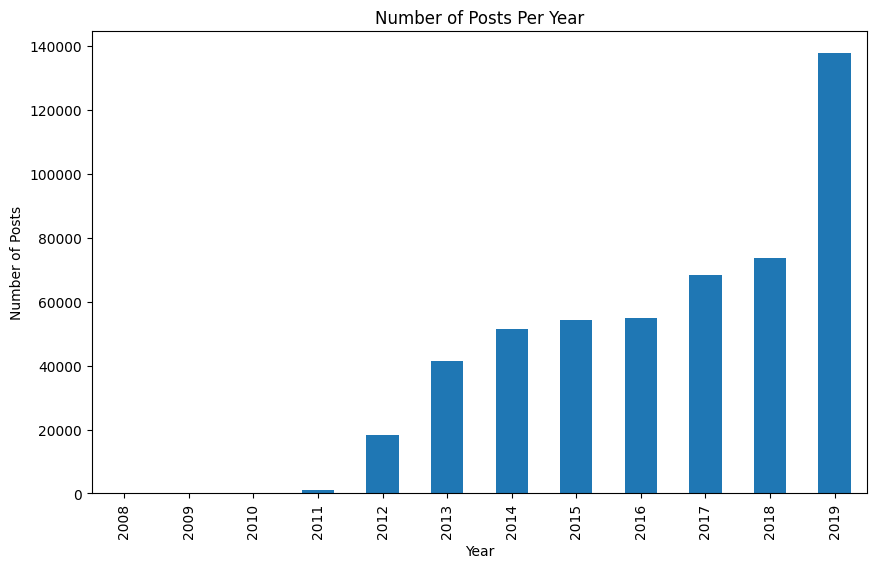

In [12]:
# Extract the year from 'created_utc' and create a new column 'created_year'
df['created_year'] = df['created_utc'].dt.year

# Plot the number of posts per year
plt.figure(figsize=(10, 6))
df.groupby('created_year').size().plot(kind='bar')
plt.title('Number of Posts Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.show()

**Plot the 6- Way Class Distribution of dataset:**
- 0: TRUE
- 1: SATIRE
- 2: FALSE CONNECTION
- 3: IMPOSTER CONTENT
- 4: MANIPULATED CONTENT
- 5: MISLEADING CONTENT

<Axes: title={'center': '6_way_label'}, ylabel='Frequency'>

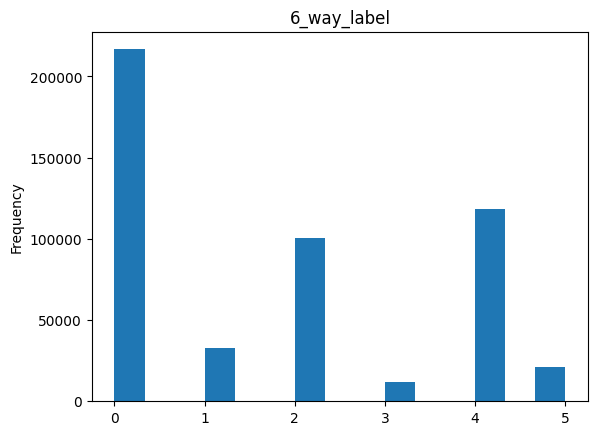

In [13]:
# Plot a histogram for the column '6_way_label'
# - kind="hist": Specifies that the plot type is a histogram
# - bins=15: Divides the data into 15 intervals (bins) for the histogram
# - title="6_way_label": Sets the title of the histogram to "6_way_label"
# Based on the class distribution graph above, the classes are not represented equally in the dataset.
df["6_way_label"].plot(kind="hist", bins=15, title="6_way_label")


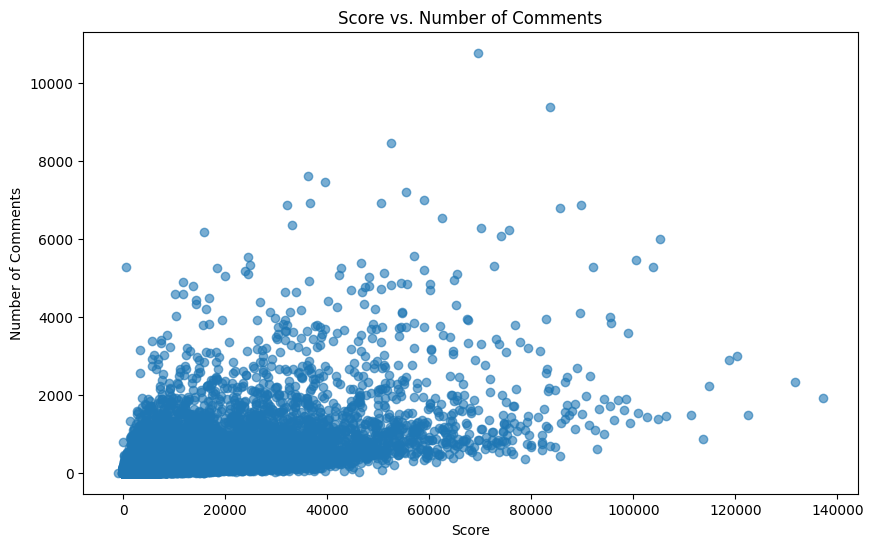

In [14]:

# Visualization : Score vs. Number of Comments
plt.figure(figsize=(10, 6))
plt.scatter(df['score'], df['num_comments'], alpha=0.6)
plt.title('Score vs. Number of Comments')
plt.xlabel('Score')
plt.ylabel('Number of Comments')
plt.show()

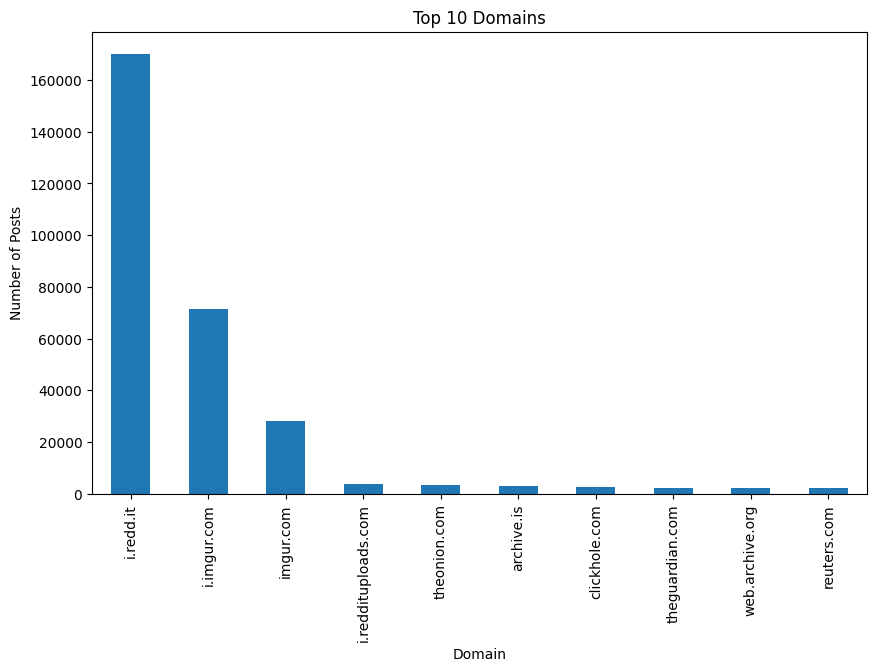

In [15]:
# Visualization : Domains Contributing to Fake News
plt.figure(figsize=(10, 6))
top_domains = df['domain'].value_counts().head(10)
top_domains.plot(kind='bar')
plt.title('Top 10 Domains')
plt.xlabel('Domain')
plt.ylabel('Number of Posts')
plt.show()

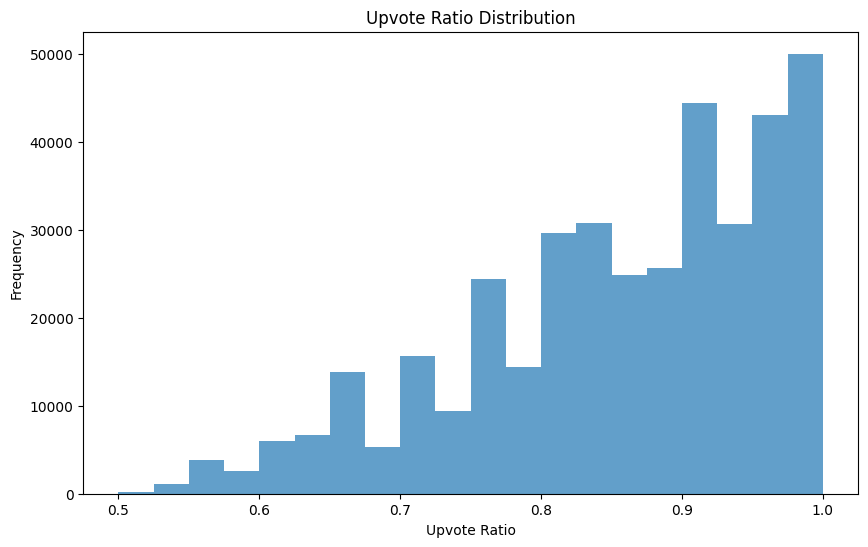

In [16]:
# Visualization : Upvote Ratio Distribution
plt.figure(figsize=(10, 6))
df['upvote_ratio'].plot(kind='hist', bins=20, alpha=0.7)
plt.title('Upvote Ratio Distribution')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')
plt.show()

# **Importing Images**

In [17]:
# Split the DataFrame `df` into training and test subsets, retaining only the training portion.
# - `test_size=0.97`: Reserves 97% of the data as the test subset (discarded here).
# - `shuffle=True`: Randomly shuffles the data before splitting.
# - `stratify=df["6_way_label"]`: Ensures the `6_way_label` column's class distribution is preserved in the split.
# Note: Only the training subset (3% of the original data) is retained in `df`, and the test subset is ignored.
df, _ = train_test_split(
    df,
    test_size=0.97,
    shuffle=True,
    stratify=df["6_way_label"]
)


In [18]:

# Replace NaN values with empty strings
df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

# Create the directory to store images if it doesn't exist
image_dir = "/kaggle/working/images"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

# Function to download a single image
def download_image(row):
    image_url = row["image_url"]
    image_path = os.path.join(image_dir, f"{row['id']}.jpg")

    try:
        # Download the image and save it to the file path
        with open(image_path, 'wb') as f:
            f.write(request.urlopen(image_url).read())
        return True  # Success
    except Exception as e:
        return False  # Failed to download

# Function to process a single row in the dataframe
def process_row(index, row):
    if row["hasImage"] and row["image_url"] not in ["", "nan"]:
        success = download_image(row)
        if not success:
            # Remove the row from the dataframe if download fails
            return index
    return None

# Use ThreadPoolExecutor to download images concurrently
failed_indices = []
with ThreadPoolExecutor(max_workers=10) as executor:  # You can adjust the number of threads with max_workers
    futures = {executor.submit(process_row, index, row): index for index, row in df.iterrows()}

    for future in as_completed(futures):
        index = futures[future]
        try:
            failed_index = future.result()
            if failed_index is not None:
                failed_indices.append(failed_index)
        except Exception as exc:
            print(f"An error occurred for row {index}: {exc}")

# Remove failed rows from the dataframe
df.drop(index=failed_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

print("Downloaded all images.")


Downloaded all images.


Image 1 shape: (240, 320, 3)
Image 2 shape: (167, 320, 3)
Image 3 shape: (320, 320, 3)
Image 4 shape: (800, 600, 3)
Image 5 shape: (429, 320, 3)
Image 6 shape: (219, 320, 3)
Image 7 shape: (426, 320, 3)
Image 8 shape: (320, 320)
Image 9 shape: (168, 320, 3)
Image 10 shape: (454, 320, 3)


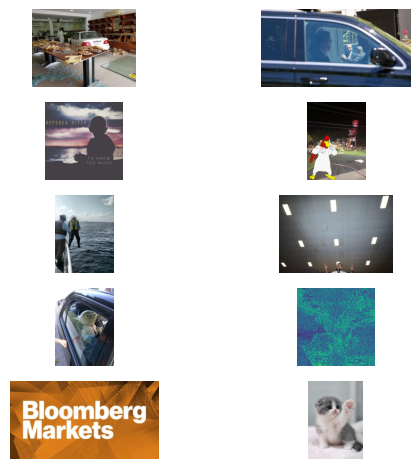

In [19]:
# Display 10 images in a grid of 2 columns and 5 rows
for i in range(10):  # Loop through 10 images
    path = "/kaggle/working/images/" + df["id"][i] + ".jpg"  # Generate the file path

    im = np.array(Image.open(path))  # Open the image and convert it to an array

    print(f"Image {i+1} shape: {im.shape}")  # Print the shape of the image
    ax = plt.subplot(5, 2, i + 1)  # Create a subplot with 5 rows, 2 columns, and current position
    ax.imshow(im)  # Display the image in the current subplot
    ax.axis('off')  # Turn off the axes for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display all the images in one figure


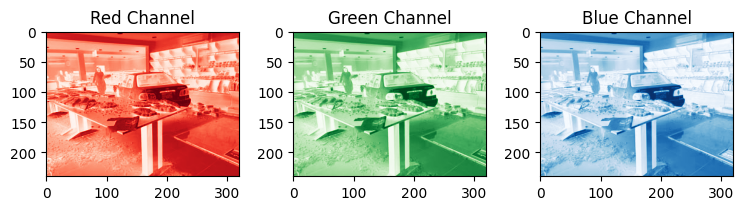

In [22]:
# Load the RGBA image and convert it to RGB format
image_path = "/kaggle/working/images/" + df["id"][0] + ".jpg"  # Construct the file path for the first image in the dataset
image = Image.open(image_path).convert("RGB")  # Open the image file and convert it to RGB format

# Split the image into individual color channels (Red, Green, and Blue)
r, g, b = image.split()  # Split the image into its red, green, and blue channels

# Plot each channel separately
plt.figure(figsize=(10, 5))  # Create a new figure with a specified size (10x5 inches)


# Plot the Blue channel
plt.subplot(1, 4, 3)  # Select the 3rd position in the 1x4 grid
plt.imshow(b, cmap='Blues')  # Display the blue channel with a blue colormap
plt.title('Blue Channel')  # Add a title to the subplot

# Plot the Red channel
plt.subplot(1, 4, 1)  # Create a subplot grid with 1 row and 4 columns, selecting the 1st position
plt.imshow(r, cmap='Reds')  # Display the red channel with a red colormap for better visualization
plt.title('Red Channel')  # Add a title to the subplot

# Plot the Green channel
plt.subplot(1, 4, 2)  # Select the 2nd position in the 1x4 grid
plt.imshow(g, cmap='Greens')  # Display the green channel with a green colormap
plt.title('Green Channel')  # Add a title to the subplot

# Adjust layout to prevent overlap between subplots
plt.tight_layout()

# Display the plotted figure
plt.show()


In [25]:
# Function to check for corrupted images in a directory
def check_image_integrity(folder_path):
    invalid_images = []  # List to store paths of corrupted images

    # Iterate through each record in the DataFrame
    for idx, record in df.iterrows():
        file_path = folder_path + record["id"] + ".jpg"  # Construct the image file path
        try:
            # Attempt to open and verify the image
            with Image.open(file_path) as picture:
                picture.verify()  # Verify if the file is a valid image
        except Exception as error:
            # If an error occurs, add the file path to the invalid images list
            invalid_images.append(file_path)
            # Remove the entry from the DataFrame as the image is corrupted
            df.drop(index=idx, axis=0, inplace=True)

    # Return the list of corrupted image file paths
    return invalid_images

# Example usage of the function
image_directory = "/kaggle/working/images/"  # Define the directory containing images
corrupted_list = check_image_integrity(image_directory)  # Call the function to validate images

# Check and print results
if corrupted_list:
    print(f"Found {len(corrupted_list)} corrupted images.")  # Inform about corrupted images found
else:
    print("All images are valid!")  # Inform if no corrupted images are found

# Reset the DataFrame index after removing invalid entries
df.reset_index(drop=True, inplace=True)

All images are valid!


In [26]:
# Define the new size to which all images will be resized
target_size = (256, 256)  # Tuple specifying width and height of the resized images

# Iterate through each record in the DataFrame
for idx, record in df.iterrows():
    # Construct the file path for the current image
    file_path = "/kaggle/working/images/" + record["id"] + ".jpg"

    # Open the image file and ensure it is in RGB format
    original_image = Image.open(file_path).convert("RGB")

    # Apply the resizing transformation
    resize_operation = v2.Resize(target_size)  # Initialize the resizing operation
    resized_image = resize_operation(original_image)  # Resize the current image

    # Save the resized image back to the original file path
    resized_image.save(file_path)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Image 1 shape: (256, 256, 3)
Image 2 shape: (256, 256, 3)
Image 3 shape: (256, 256, 3)
Image 4 shape: (256, 256, 3)
Image 5 shape: (256, 256, 3)
Image 6 shape: (256, 256, 3)
Image 7 shape: (256, 256, 3)
Image 8 shape: (256, 256, 3)
Image 9 shape: (256, 256, 3)
Image 10 shape: (256, 256, 3)


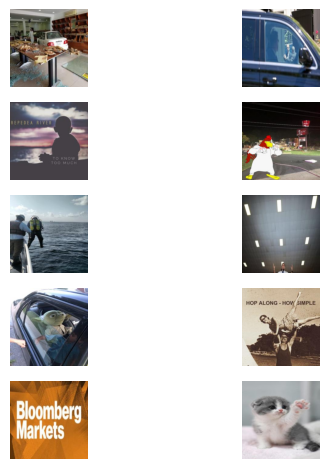

In [27]:
# Display 10 images in a grid of 2 columns and 5 rows to check they have been resized
for i in range(10):  # Loop through 10 images
    path = "/kaggle/working/images/" + df["id"][i] + ".jpg"  # Generate the file path

    im = np.array(Image.open(path))  # Open the image and convert it to an array

    print(f"Image {i+1} shape: {im.shape}")  # Print the shape of the image
    ax = plt.subplot(5, 2, i + 1)  # Create a subplot with 5 rows, 2 columns, and current position
    ax.imshow(im)  # Display the image in the current subplot
    ax.axis('off')  # Turn off the axes for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display all the images in one figure

# Set up the BERT tokenizer to standardize and process "clean_title" strings.

In [28]:
!pip install --quiet transformers

In [29]:
# Import the BertModel and BertTokenizer classes from the transformers library.
# These are used for working with pre-trained BERT models and tokenizing text.
from transformers import BertModel, BertTokenizer

# Define the identifier for the pre-trained BERT model to be used.
# "bert-base-uncased" is a commonly used version of BERT with a smaller size and uncased vocabulary.
model_identifier = "bert-base-uncased"

# Initialize the BERT tokenizer using the pre-trained model identifier.
# The tokenizer is responsible for converting text into tokens that the BERT model can process.
tokenizer = BertTokenizer.from_pretrained(model_identifier)

# Load the pre-trained BERT model using the specified identifier.
# The parameter `output_hidden_states=True` configures the model to output its hidden states (useful for advanced tasks).
bert_model = BertModel.from_pretrained(model_identifier, output_hidden_states=True)

# Set the BERT model to evaluation mode.
# This disables dropout regularization, which is used during training, to ensure consistent outputs during inference.
bert_model.eval()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [31]:
# Define a function to generate BERT embeddings for a given text input
def get_bert_embedding(text):
    # Tokenize the input text using the BERT tokenizer
    # encode_plus tokenizes the text and provides additional outputs like attention masks
    inputs = tokenizer.encode_plus(
        text,  # The input text to be tokenized
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens required by BERT
        return_tensors="pt",  # Return the tokenized output as PyTorch tensors
        max_length=80,  # Set the maximum sequence length to 80 tokens
        truncation=True,  # Truncate the input text if it exceeds the maximum length
        padding="max_length"  # Pad the input text to the maximum length if it's shorter
    )

    # Return the tokenized input IDs and attention mask, removing the batch dimension (squeeze)
    return inputs["input_ids"].squeeze(0), inputs["attention_mask"].squeeze(0)


# Example usage: Test the function by generating BERT embeddings for a sample text
text = "this is an embedding example for fake news detection"  # Input text
input_ids, attention_mask = get_bert_embedding(text=text)  # Get input IDs and attention mask

# Print the shape of the input IDs tensor (sequence length)
print(input_ids.shape)

# Print the shape of the attention mask tensor (sequence length)
print(attention_mask.shape)

# Print the tokenized input IDs (numerical representation of text)
print(input_ids)

# Print the attention mask (indicates which tokens are actual input and which are padding)
print(attention_mask)


torch.Size([80])
torch.Size([80])
tensor([  101,  2023,  2003,  2019,  7861,  8270,  4667,  2742,  2005,  8275,
         2739, 10788,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
